In [68]:
import pandas as pd
import time
from urllib.request import urlretrieve
from unipressed import IdMappingClient, UniprotkbClient
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from tempfile import gettempdir
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from tqdm import tqdm
tqdm.pandas()

In [69]:
GOTERM_CATEGORIES = ['molecular_function', 'biological_process', 'cellular_component']
obo_file = Path(gettempdir()) / 'go.obo'
obo_slim_file = Path(gettempdir()) / 'goslim_generic.obo'
GO_OBO_PERMANENT_LINK = 'http://purl.obolibrary.org/obo/go.obo'
GOSLIM_GENERIC_OBO_PERMANENT_LINK = ('https://current.geneontology.org/ontology/subsets/goslim_generic.obo')
print('Downloading obo file')
urlretrieve(GO_OBO_PERMANENT_LINK, obo_file)
print('Downloading goslim obo file')
urlretrieve(GOSLIM_GENERIC_OBO_PERMANENT_LINK, obo_slim_file)

godag = GODag(obo_file)
goslim_dag = GODag(obo_slim_file)

/tmp/go.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms
/tmp/goslim_generic.obo: fmt(1.2) rel(go/2024-06-17/subsets/goslim_generic.owl) 206 Terms


In [78]:
def get_uniprot_ids(tair_ids: list):    
    request = IdMappingClient.submit(source="Gene_Name", dest="UniProtKB", ids=tair_ids)
    while request.get_status() != 'FINISHED':
        time.sleep(1)
    return list(request.each_result())

def get_go_terms(uniprot_id: str):
    go_ids = []
    record_dict = UniprotkbClient.fetch_one(uniprot_id)
    if uniprotkb_crossrefs := record_dict['uniProtKBCrossReferences']:
        for cross_ref_dict in get_specific_cross_references(uniprotkb_crossrefs, dbname='GO'):
            if 'id' in cross_ref_dict:
                go_ids.append(cross_ref_dict['id'])
    return go_ids

def get_specific_cross_references(uniprotkb_crossrefs: list, dbname: str):
    if not isinstance(uniprotkb_crossrefs, list):
        return []
    return [
        cross_ref_dict for cross_ref_dict in uniprotkb_crossrefs
        if cross_ref_dict.get('database') == dbname
    ]

def merge_go_term_list(group: list):
    merged_go_term_list = []
    for group in group:
        merged_go_term_list += group
    return merged_go_term_list


def get_goslims(go_term: str):
    return list(mapslim(go_term, godag, goslim_dag)[1])
    

def get_goslim_mappings(row: pd.Series):
    goslim_lists = []
    for go_term in row['go_terms']:
        try:
            goslims = get_goslims(go_term)
        except:
            print(f'Could not get goslim from {go_term}')
        else:
            if goslims:
                goslim_lists.append(goslims)
    goslim_name_lists = [[godag[goslim].name for goslim in goslim_list] for goslim_list in goslim_lists]
    return goslim_lists, goslim_name_lists

def get_specific_goslim_mappings(row: pd.Series, namespace: str):
    filtered_goslims = list(set([
        goslim_list[-1] for goslim_list in row['goslim_terms'] 
        if godag[goslim_list[-1]].namespace == namespace
    ]))
    filtered_goslim_names = [godag[goslim].name for goslim in filtered_goslims]
    return filtered_goslims, filtered_goslim_names


def go_term_corresponds_to_goslim(go_term: str, goslim_name: str):
    try:
        goslims = get_goslims(go_term)
    except:
        return False
    else:
        for goslim in goslims:
            if godag[goslim].name == goslim_name:
                return True
        return False

def keep_go_term_corresponding_to_goslim(go_terms: list, goslim_name: str):
    return [go_term for go_term in go_terms if go_term_corresponds_to_goslim(go_term, goslim_name)]

In [12]:
file = '/home/olivier/WindowsShared/TEST GO.csv'
df = pd.read_csv(file, names=['tair_id'])
tair_ids = [tair_id.split('.')[0] for tair_id in df['tair_id'].tolist() if tair_id != 'RPS4TIR-MiniTurbo3flag']

In [16]:
tair_ids_to_uniprot_ids = get_uniprot_ids(tair_ids)

In [19]:
df = pd.DataFrame.from_records(tair_ids_to_uniprot_ids).rename(columns={'from': 'tair_id', 'to': 'uniprot_id'})
df['go_terms'] = df['uniprot_id'].progress_apply(get_go_terms)

100%|██████████| 942/942 [02:15<00:00,  6.98it/s]


In [24]:
df1 = df.groupby('tair_id')['go_terms'].apply(merge_go_term_list).reset_index()
df1[['goslim_terms', 'goslim_names']] = df1.apply(lambda row: get_goslim_mappings(row),axis=1, result_type='expand')

Could not get goslim from GO:0043621
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:0019438
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:0000291
Could not get goslim from GO:0052747
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:0045330
Could not get goslim from GO:1901576
Could not get goslim from GO:0043621
Could not get goslim from GO:1901576
Could not get goslim from GO:1901576
Could not get goslim from GO:1901528
Could not get goslim from GO:1901576


In [25]:
for namespace in GOTERM_CATEGORIES:
    df1[[f'{namespace}_goslim_terms', f'{namespace}_goslim_names']] = df1.apply(
        lambda row: get_specific_goslim_mappings(row, namespace=namespace), axis=1, result_type='expand')

In [26]:
df1

,tair_id,go_terms,goslim_terms,goslim_names,molecular_function_goslim_terms,molecular_function_goslim_names,biological_process_goslim_terms,biological_process_goslim_names,cellular_component_goslim_terms,cellular_component_goslim_names
0,AT1G01320,"[GO:0005829, GO:0005576, GO:0005634, GO:000372...","[[GO:0005829], [GO:0005576], [GO:0005634, GO:0...","[[cytosol], [extracellular region], [nucleus, ...",[GO:0003723],[RNA binding],[],[],"[GO:0005829, GO:0005576, GO:0043226]","[cytosol, extracellular region, organelle]"
1,AT1G01440,"[GO:1900150, GO:1900150]",[],[],[],[],[],[],[],[]
2,AT1G01510,"[GO:0010494, GO:0005829, GO:0005874, GO:000580...","[[GO:0043226], [GO:0005829], [GO:0016491, GO:0...","[[organelle], [cytosol], [oxidoreductase activ...","[GO:0003824, GO:0060090]","[catalytic activity, molecular adaptor activity]","[GO:0007010, GO:0022414]","[cytoskeleton organization, reproductive process]","[GO:0005829, GO:0043226]","[cytosol, organelle]"
3,AT1G01560,"[GO:0005829, GO:0005634, GO:0005524, GO:000470...","[[GO:0005829], [GO:0005634, GO:0043226], [GO:0...","[[cytosol], [nucleus, organelle], [transferase...",[GO:0003824],[catalytic activity],[],[],"[GO:0005829, GO:0043226]","[cytosol, organelle]"
4,AT1G01680,"[GO:0004842, GO:0016567]","[[GO:0016740, GO:0140096, GO:0003824]]","[[transferase activity, catalytic activity, ac...",[GO:0003824],[catalytic activity],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...
433,AT5G64430,"[GO:0009941, GO:0009536]","[[GO:0009536, GO:0043226]]","[[plastid, organelle]]",[],[],[],[],[GO:0043226],[organelle]
434,AT5G64870,"[GO:0005901, GO:0000325, GO:0044853, GO:000953...","[[GO:0005773, GO:0043226], [GO:0009536, GO:004...","[[vacuole, organelle], [plastid, organelle], [...",[],[],[GO:0072659],[protein localization to plasma membrane],[GO:0043226],[organelle]
435,AT5G66620,"[GO:0046872, GO:0043130, GO:0046872, GO:004313...",[],[],[],[],[],[],[],[]
436,AT5G67340,"[GO:0004842, GO:0016567]","[[GO:0016740, GO:0140096, GO:0003824]]","[[transferase activity, catalytic activity, ac...",[GO:0003824],[catalytic activity],[],[],[],[]


In [88]:
def plot_counts(goterms_lists: list, subplot_index: int):
    all_goterms = []
    for goterm_list in goterms_lists:
        all_goterms += goterm_list
    all_goterms = list(all_goterms)
    all_names = [godag[goslim].name for goslim in all_goterms]
    all_names_counter = Counter(all_names)
    namespace_df = pd.Series(dict(all_names_counter), name='counts').reset_index()
    namespace_df.columns = ['goslim', 'percentage']
    namespace_df['percentage'] = namespace_df['percentage'] / all_names_counter.total()
    namespace_df.sort_values(by='percentage', ascending=False, inplace=True)
    subdf = namespace_df.head(20)
    # plot
    palette = sns.color_palette("Accent", n_colors=len(subdf))
    bars = sns.barplot(x='goslim', y='percentage', hue='goslim', data=subdf, ax=axes[subplot_index], palette=palette, legend=False)
    for j, bar in enumerate(bars.patches):
        bar.set_color(palette[j])
    axes[subplot_index].set_title(namespace)
    axes[subplot_index].set_ylabel('Percentage')
    axes[subplot_index].set_xlabel(None)
    axes[subplot_index].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

/tmp/ipykernel_24559/657195976.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[subplot_index].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_24559/657195976.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[subplot_index].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_24559/657195976.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[subplot_index].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


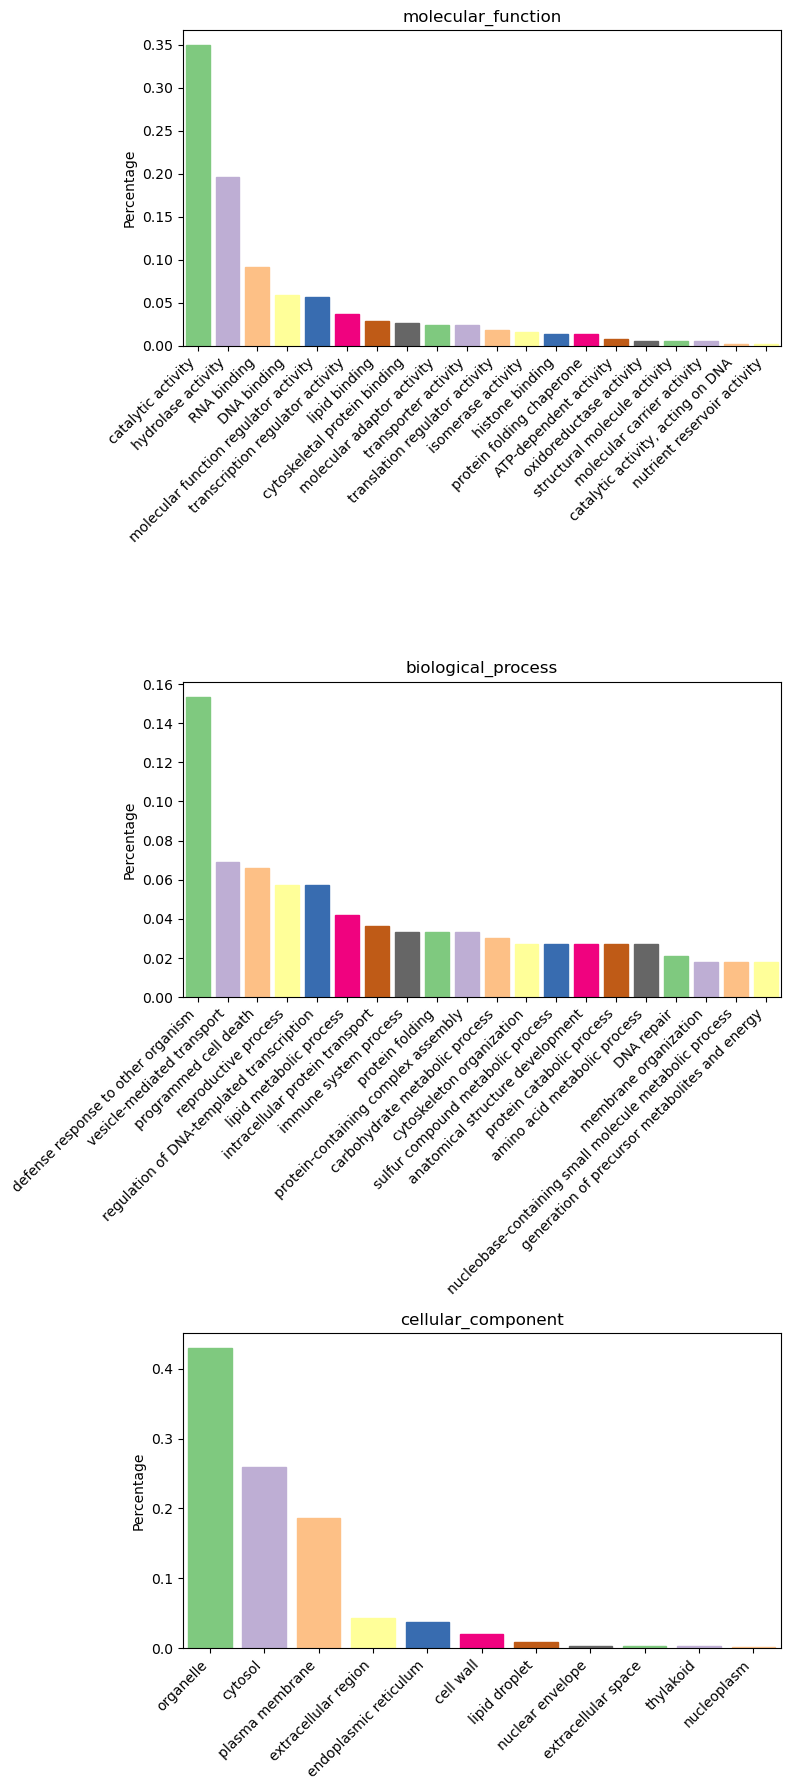

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))
for i, namespace in enumerate(GOTERM_CATEGORIES):
    goslims_lists = df1[f'{namespace}_goslim_terms'].tolist()
    plot_counts(goslims_lists, subplot_index=i)
plt.tight_layout()
plt.show()

In [90]:
def plot_one_count(goterms_lists: list):
    all_goterms = []
    for goterm_list in goterms_lists:
        all_goterms += goterm_list
    all_goterms = list(all_goterms)
    all_names = [godag[goslim].name for goslim in all_goterms]
    all_names_counter = Counter(all_names)
    namespace_df = pd.Series(dict(all_names_counter), name='counts').reset_index()
    namespace_df.columns = ['goslim', 'percentage']
    namespace_df['percentage'] = namespace_df['percentage'] / all_names_counter.total()
    namespace_df.sort_values(by='percentage', ascending=False, inplace=True)
    subdf = namespace_df.head(20)
    # plot
    palette = sns.color_palette("Accent", n_colors=len(subdf))
    bars = sns.barplot(x='goslim', y='percentage', hue='goslim', data=subdf, palette=palette, legend=False)
    for j, bar in enumerate(bars.patches):
        bar.set_color(palette[j])

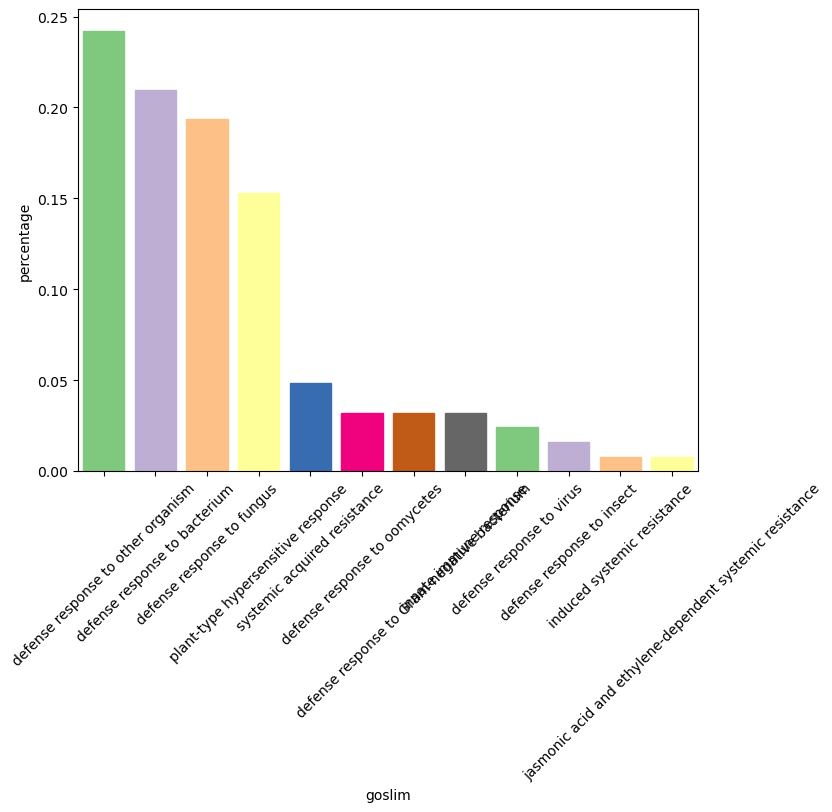

In [93]:
goslim_name = 'defense response to other organism'
func = partial(keep_go_term_corresponding_to_goslim, goslim_name=goslim_name)
filtered_goterms = df1['go_terms'].apply(func)

plt.figure(figsize=(8, 6))
specific_go_terms = filtered_goterms.tolist()
plot_one_count(specific_go_terms)
plt.xticks(rotation=45)
plt.show()